# Streuung der Deadlines

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pd.set_option('display.max_rows', 30)

In [3]:
import utils.scheduling_solver as ssv

import utils.schedule_deadline as deadline_gen
import utils.rolling_planning.init_jobs_times as rp_init

## Generierung des Datensatzes für 17 Tage (Ankunft)

In [5]:
df_instance = pd.read_csv("data/00_instance.csv")

df_jssp, df_arrivals = rp_init.init_jobs_with_arrivals(df_instance, 9,  u_b_mmax = 0.96)
df_jssp

,Job,Operation,Machine,Processing Time
0,Job_000,0,M0,29
1,Job_000,1,M1,78
2,Job_000,2,M2,9
3,Job_000,3,M3,36
4,Job_000,4,M4,49
...,...,...,...,...
1705,Job_170,5,M9,76
1706,Job_170,6,M5,47
1707,Job_170,7,M3,52
1708,Job_170,8,M4,90


In [6]:
df_times_all = deadline_gen.get_times_df(df_jssp, df_arrivals, ssv.schedule_fcfs_with_arrivals, target_service=1.0)
df_times_all.rename(columns={"Deadline": "Deadline_original"}, inplace=True)
df_times_all

,Job,Arrival,Deadline_original
0,Job_000,0.00,1159
1,Job_001,82.55,1579
2,Job_002,143.24,1810
3,Job_003,194.98,2117
4,Job_004,231.20,1384
...,...,...,...
166,Job_166,12636.49,14558
167,Job_167,12642.49,13796
168,Job_168,12643.83,14310
169,Job_169,12761.32,13920


In [7]:
df_proc_time = df_jssp.groupby("Job", as_index=False)["Processing Time"].sum()
df_proc_time

,Job,Processing Time
0,Job_000,395
1,Job_001,510
2,Job_002,568
3,Job_003,655
4,Job_004,393
...,...,...
166,Job_166,655
167,Job_167,393
168,Job_168,568
169,Job_169,395


In [8]:
df_times_all = df_times_all.merge(df_proc_time, on="Job", how="left")
df_times_all

,Job,Arrival,Deadline_original,Processing Time
0,Job_000,0.00,1159,395
1,Job_001,82.55,1579,510
2,Job_002,143.24,1810,568
3,Job_003,194.98,2117,655
4,Job_004,231.20,1384,393
...,...,...,...,...
166,Job_166,12636.49,14558,655
167,Job_167,12642.49,13796,393
168,Job_168,12643.83,14310,568
169,Job_169,12761.32,13920,395


# Normalverteilung

In [10]:
df_times = df_times_all.copy()
df_times

,Job,Arrival,Deadline_original,Processing Time
0,Job_000,0.00,1159,395
1,Job_001,82.55,1579,510
2,Job_002,143.24,1810,568
3,Job_003,194.98,2117,655
4,Job_004,231.20,1384,393
...,...,...,...,...
166,Job_166,12636.49,14558,655
167,Job_167,12642.49,13796,393
168,Job_168,12643.83,14310,568
169,Job_169,12761.32,13920,395


In [11]:
# Slack berechnen
df_times["Slack"] = df_times["Deadline_original"] - df_times["Arrival"]


# Standardabweichung (und Mittelwert)der Slack-Zeiten
std_slack = df_times["Slack"].std()
mean_slack = df_times["Slack"].mean()

print(f"Mean Slack: {mean_slack:.2f}")
print(f"Standard Deviation of Slack: {std_slack:.2f}")

Mean Slack: 1513.72
Standard Deviation of Slack: 243.20


In [12]:
np.random.seed(50)

# Berechne eine gestreute Deadline für jede Zeile:
# - Ziehe einen Wert aus einer Normalverteilung mit Mittelwert = Deadline und Streuung = std_slack
# - Stelle sicher, dass die gestreute Deadline mindestens "Arrival + Processing Time" ist
# - Weist das Ergebnis der Spalte "Gestreute_Deadline" zu

df_times["Deadline"] = df_times.apply(
    lambda row: max(
        np.random.normal(
            loc=row["Deadline_original"],         # Mittelwert = ursprüngliche Deadline
            scale=std_slack                       # konstante Standardabweichung für alle Jobs
        ),
        row["Arrival"] + row["Processing Time"]   # Minimum: frühestmögliche sinnvolle Deadline
    ),
    axis=1  # sorgt dafür, dass apply zeilenweise arbeitet
)

# Aufrunden auf nächsten ganzzahligen Wert
df_times["Deadline"] = np.ceil(df_times["Deadline"])

In [13]:
df_times["Abweichung"] = df_times["Deadline"] - df_times["Deadline_original"]
df_times.sort_values(by="Abweichung", ascending=True).head(15)

,Job,Arrival,Deadline_original,Processing Time,Slack,Deadline,Abweichung
83,Job_083,6243.42,7825,539,1581.58,6899.0,-926.0
89,Job_089,6871.65,8327,496,1455.35,7702.0,-625.0
109,Job_109,8316.49,10238,655,1921.51,9644.0,-594.0
81,Job_081,6059.44,7515,496,1455.56,6938.0,-577.0
162,Job_162,12356.22,13938,539,1581.78,13482.0,-456.0
116,Job_116,8783.24,10450,568,1666.76,10035.0,-415.0
44,Job_044,3217.27,4438,416,1220.73,4033.0,-405.0
79,Job_079,5954.98,7877,655,1922.02,7491.0,-386.0
117,Job_117,8834.98,10757,655,1922.02,10372.0,-385.0
137,Job_137,10311.20,11464,393,1152.8,11081.0,-383.0


In [14]:
df_times.sort_values(by="Abweichung", ascending=False).head(15)

,Job,Arrival,Deadline_original,Processing Time,Slack,Deadline,Abweichung
16,Job_016,1123.83,2790,568,1666.17,3596.0,806.0
52,Job_052,3996.49,5918,655,1921.51,6576.0,658.0
135,Job_135,10223.24,11890,568,1666.76,12490.0,600.0
76,Job_076,5760.00,6919,395,1159.0,7422.0,503.0
120,Job_120,8977.27,10198,416,1220.73,10638.0,440.0
27,Job_027,2141.31,3893,597,1751.69,4310.0,417.0
146,Job_146,11191.65,12647,496,1455.35,13045.0,398.0
93,Job_093,7001.32,8160,395,1158.68,8555.0,395.0
15,Job_015,1122.49,2276,393,1153.51,2665.0,389.0
94,Job_094,7100.30,8685,540,1584.7,9056.0,371.0


In [15]:
real_deviation = df_times["Abweichung"]

max_abw = real_deviation.max()
min_abw = real_deviation.min()

print(f"Ø Abweichung: {real_deviation.mean():.2f}")
print(f"Größte positive Abweichung: {max_abw:.2f}")
print(f"Größte negative Abweichung: {min_abw:.2f}")

Ø Abweichung: -13.41
Größte positive Abweichung: 806.00
Größte negative Abweichung: -926.00


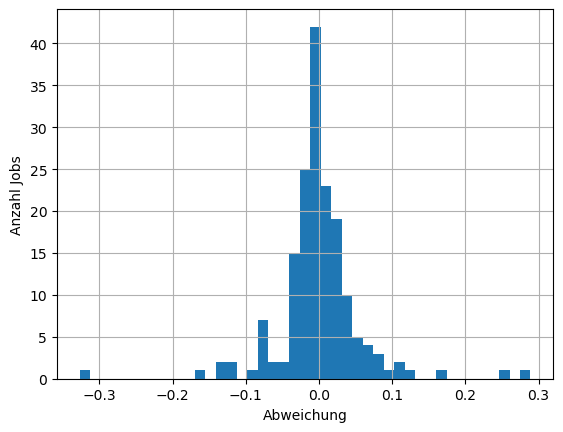

In [16]:
relative_abweichung =  (df_times["Deadline"] - df_times["Deadline_original"]) / df_times["Deadline_original"]
plt.hist(relative_abweichung , bins="auto")
plt.xlabel("Abweichung")
plt.ylabel("Anzahl Jobs")
plt.grid(True)
plt.show()

### Dreiecksverteilung

In [18]:
df_times = df_times_all.copy()
df_times

,Job,Arrival,Deadline_original,Processing Time
0,Job_000,0.00,1159,395
1,Job_001,82.55,1579,510
2,Job_002,143.24,1810,568
3,Job_003,194.98,2117,655
4,Job_004,231.20,1384,393
...,...,...,...,...
166,Job_166,12636.49,14558,655
167,Job_167,12642.49,13796,393
168,Job_168,12643.83,14310,568
169,Job_169,12761.32,13920,395


In [19]:
np.random.seed(45)

df_times["Deadline"] = df_times.apply(
    lambda row: np.random.triangular(
        left=row["Arrival"] + row["Processing Time"],   # frühestmögliches Ende
        mode=row["Deadline_original"],                  # Peak der Verteilung
        right=2 * row["Deadline_original"] - (row["Arrival"] + row["Processing Time"])  # symmetrisches Maximum
    ),
    axis=1
)

# Aufrunden auf nächsten ganzzahligen Wert
df_times["Deadline"] = np.ceil(df_times["Deadline"])

In [20]:
# Streuwert
df_times["Abweichung"] = df_times["Deadline"] - df_times["Deadline_original"]
min_abw = df_times["Abweichung"].min()
max_abw = df_times["Abweichung"].max()
mean_abw = df_times["Abweichung"].mean()

print(f"Minimale Abweichung: {min_abw:.2f}")
print(f"Maximale Abweichung: {max_abw:.2f}")
print(f"Mittlere Abweichung: {mean_abw:.2f}")

Minimale Abweichung: -790.00
Maximale Abweichung: 1095.00
Mittlere Abweichung: -15.72


In [21]:
df_times.sort_values(by="Abweichung", ascending=True).head(15)

,Job,Arrival,Deadline_original,Processing Time,Deadline,Abweichung
78,Job_078,5903.24,7570,568,6780.0,-790.0
3,Job_003,194.98,2117,655,1349.0,-768.0
109,Job_109,8316.49,10238,655,9475.0,-763.0
104,Job_104,7933.09,9518,540,8785.0,-733.0
49,Job_049,3765.69,5517,597,4786.0,-731.0
27,Job_027,2141.31,3893,597,3185.0,-708.0
59,Job_059,4463.24,6130,568,5425.0,-705.0
113,Job_113,8540.30,10125,540,9485.0,-640.0
117,Job_117,8834.98,10757,655,10134.0,-623.0
8,Job_008,701.31,2453,597,1855.0,-598.0


In [22]:
df_times.sort_values(by="Abweichung", ascending=False).head(15)

,Job,Arrival,Deadline_original,Processing Time,Deadline,Abweichung
71,Job_071,5436.49,7358,655,8453.0,1095.0
106,Job_106,8085.69,9837,597,10829.0,992.0
84,Job_084,6461.31,8213,597,9189.0,976.0
56,Job_056,4220.30,5805,540,6664.0,859.0
16,Job_016,1123.83,2790,568,3648.0,858.0
12,Job_012,940.87,2437,510,3289.0,852.0
130,Job_130,9763.83,11430,568,12237.0,807.0
165,Job_165,12631.65,14087,496,14872.0,785.0
52,Job_052,3996.49,5918,655,6686.0,768.0
86,Job_086,6596.22,8178,539,8863.0,685.0


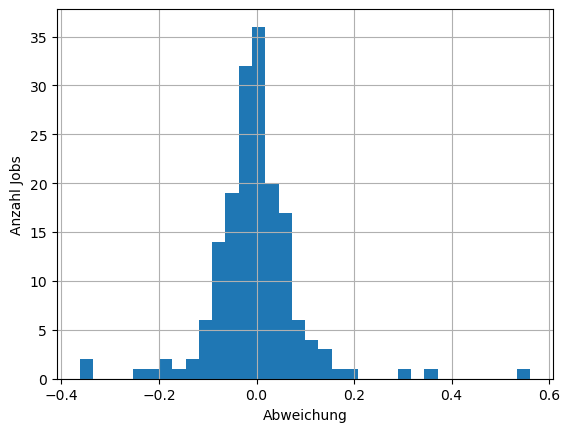

In [23]:
relative_abweichung =  (df_times["Deadline"] - df_times["Deadline_original"]) / df_times["Deadline_original"]
plt.hist(relative_abweichung , bins="auto")
plt.xlabel("Abweichung")
plt.ylabel("Anzahl Jobs")
plt.grid(True)
plt.show()